In [1]:
%matplotlib notebook
%autosave 0
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import animation
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
import pickle
#from sklearn import svm, datasets
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix, classification_report, balanced_accuracy_score
from tqdm.notebook import tqdm

Autosave disabled


In [2]:
import sys
sys.path.append("../imbalanced_dataset_sampler/torchsampler/")
sys.path.append("../libs")
from vvv_utils import parse_metadata, parse_light_curve_data, plot_light_curve, get_train_test_ids
from imbalanced import ImbalancedDatasetSampler
from Modulin import LightCurve_Dataset, PartialConv, MLP_last
from training2 import *

**Cargar LCs**

In [3]:
df_meta = parse_metadata(experiment="ALL", merge_subclasses=True)

88454 light curve metadata collected


In [8]:
df_meta

,P1,P2,P_ogle,label
ID_VVV,,,,
b221_201_22183,13.972335,6.986167,13.970992,binary
b221_205_41463,21.537799,10.770059,21.541892,binary
b232_614_24529,8.035356,16.069420,16.065114,binary
b233_201_30278,8.750438,4.374645,8.751487,binary
b233_201_16631,44.130627,22.070183,44.161985,binary
...,...,...,...,...
b395_201_28153,0.316792,0.633585,0.316787,rrlyrae
b395_205_6265,0.287350,0.574699,0.287350,rrlyrae
b395_304_9934,0.355847,0.711693,0.355842,rrlyrae


In [22]:

VVV_dict = {idx: i for i,idx in enumerate(df_meta.index.values)}
#VVV_dict

{'b221_201_22183': 0,
 'b221_205_41463': 1,
 'b232_614_24529': 2,
 'b233_201_30278': 3,
 'b233_201_16631': 4,
 'b233_501_23259': 5,
 'b234_114_15972': 6,
 'b234_116_22872': 7,
 'b234_209_6698': 8,
 'b234_306_33954': 9,
 'b234_416_25888': 10,
 'b234_513_21055': 11,
 'b234_515_27237': 12,
 'b234_505_5178': 13,
 'b235_114_15972': 14,
 'b235_116_22872': 15,
 'b235_209_6698': 16,
 'b235_306_33954': 17,
 'b235_416_25888': 18,
 'b235_513_21055': 19,
 'b235_515_27237': 20,
 'b235_505_5178': 21,
 'b237_314_33464': 22,
 'b237_404_5567': 23,
 'b237_505_2352': 24,
 'b237_505_41690': 25,
 'b237_507_6442': 26,
 'b238_402_38875': 27,
 'b242_213_35192': 28,
 'b242_205_42093': 29,
 'b242_306_4035': 30,
 'b242_410_10317': 31,
 'b242_412_22693': 32,
 'b242_414_10169': 33,
 'b242_509_44836': 34,
 'b245_213_49548': 35,
 'b245_314_36310': 36,
 'b245_513_45155': 37,
 'b246_211_11259': 38,
 'b246_207_5881': 39,
 'b246_304_25163': 40,
 'b246_306_28172': 41,
 'b246_404_17697': 42,
 'b246_513_10796': 43,
 'b246_

In [24]:
VVV_dict['b246_404_17697']

42

**Datasets con periodos p1,p2 y p_Ogle**

In [4]:
VVV_p1= LightCurve_Dataset(df_meta, 'P1')
VVV_p2= LightCurve_Dataset(df_meta, 'P2')
VVV_pO= LightCurve_Dataset(df_meta, 'P_ogle')

In [5]:
# GUARDAR Datasets with period 
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_p1.pkl', 'wb') as handle:
    pickle.dump(VVV_p1, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_p2.pkl', 'wb') as handle:
    pickle.dump(VVV_p2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_pO.pkl', 'wb') as handle:
    pickle.dump(VVV_pO, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_p1.pkl', 'rb') as handle:
    VVV_p1 = pickle.load(handle)
    
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_p2.pkl', 'rb') as handle:
    VVV_p2 = pickle.load(handle)
    
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_pO.pkl', 'rb') as handle:
    VVV_pO = pickle.load(handle)

In [5]:
def make_path(n,s):
    n_model = '0'+str(n)
    #path = '/home/amorales/tesis/LC_test/models/LCC_newDataset_model_'+n_model+'_'
    path = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/LCC_newDataset_model_'+n_model+'_'
    comentario = "sample_"+str(s)
    path_full = path+comentario+'.pt'
    return path_full

**Modelo**

In [6]:
modelo = MLP_last()

In [6]:
cuda.is_available()

True

**Split data**

In [7]:
train_valid_idx, test_idx = get_train_test_ids(df_meta,test_size=0.1)
# usar valid_idx sólo para validar, matriz de confusion final

# pasamos de tipo Int64Index a int32
#train_valid_idx, test_idx = np.array(train_valid_idx,dtype='int32'), np.array(test_idx, dtype='int32')

# slice por iloc del df_meta
df_train = df_meta.loc[train_valid_idx]
# sub dividir train_test_idx para train y test (un 20%)
train_idx, valid_idx = get_train_test_ids(df_train, test_size=0.2)

In [38]:
test_idx

Index(['b292_402_83438', 'b381_112_23559', 'b276_211_91437', 'b302_308_51394',
       'b375_616_45129', 'b262_308_53888', 'b259_616_35329', 'b292_213_30796',
       'DEK_32', 'b351_515_6740',
       ...
       'b297_306_24887', 'b298_302_24665', 'b311_306_72394', 'b366_211_33061',
       'b267_505_20705', 'b293_211_15629', 'b348_416_64838', 'b283_211_27467',
       'b362_106_54099', 'b387_602_1121'],
      dtype='object', name='ID_VVV', length=8846)

In [29]:
VVV_test_p1 = LightCurve_Dataset(df_meta.loc[test_idx],'P1')
VVV_test_p2 = LightCurve_Dataset(df_meta.loc[test_idx],'P2')
VVV_test_pO = LightCurve_Dataset(df_meta.loc[test_idx],'P_ogle')

In [8]:
VVV_p1['b298_302_24665']

{'data': tensor([[ 1.9347e-03, -1.1945e-01,  3.2447e-01,  1.5986e+03,  1.0000e+00],
         [ 6.9985e-03, -6.7604e-01,  5.4162e-01,  7.3196e+02,  1.0000e+00],
         [ 1.0001e-02, -7.4717e-01,  3.1324e-01,  1.5986e+03,  1.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]),
 'label': 0,
 'name': 'b298_302_24665',
 'period': 1.8638290000000002,
 'amplitud': 0.08013066015558404}

**Dataloaders**

In [9]:
def make_dataloaders(dataset,use_IDS,train_size=32,test_size=64):
    global train_idx
    global valid_idx
    if use_IDS:
        train_loader = DataLoader(dataset,
                          sampler=ImbalancedDatasetSampler(dataset,
                                                           indices=train_idx,
                                                           callback_get_label= lambda dataset, idx:dataset[idx]['label']),
                          batch_size=train_size, shuffle=False)

        valid_loader= DataLoader(dataset,
                                sampler=SubsetRandomSampler(valid_idx),
                                batch_size=test_size, shuffle=False)
    else:
        train_idx, test_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(train_idx),
                                batch_size=train_size, shuffle=False)

        valid_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(valid_idx),
                                batch_size=test_size, shuffle=False)
    return train_loader, valid_loader

**Paths**

In [10]:
n_model = '06b'
path_models = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/'
path_results = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/results/'
model_name = 'LCC_newDataset_model_'+n_model+'_'
path = path_models+model_name

Parametros

In [11]:
n_epochs=750
lr=0.0002
wd = 0
epochs = range(n_epochs)
use_gpu = True
use_IDS = True
criterion = torch.nn.CrossEntropyLoss()
semilla=774892200
rs=RandomState(semilla)
train_size,test_size=32,64
#sb.set(font_scale=1.0)

## TESTING

In [12]:
modelo = MLP_last(use_period=False, use_amp=False)
if use_gpu:
    modelo = modelo.cuda()

In [13]:
train_loader, valid_loader = make_dataloaders(VVV_pO,use_IDS,train_size,test_size)

In [14]:
for batch in train_loader:
    inputs, labels,period,amp = batch['data'],batch['label'],batch['period'],batch['amplitud']
    if use_gpu:
        inputs, labels,period,amp  = inputs.cuda(), labels.cuda(),period.cuda(),amp.cuda() 
    inputs = inputs.transpose(1,2)
    period,amp = period.unsqueeze(-1).float(),amp.unsqueeze(-1).float()
    display(inputs.shape,labels.shape,period.shape,amp.shape )
    #break
    data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
    #display(data.shape,mask.shape)
    #display(period,amp)
    #optimizer.zero_grad()
    outputs = modelo.forward(data,mask,torch.log(period),amp,t=0)
    display(outputs.shape,labels.shape)
    break

torch.Size([32, 5, 335])

torch.Size([32])

torch.Size([32, 1])

torch.Size([32, 1])

torch.Size([32, 3])

torch.Size([32])

<IPython.core.display.Javascript object>


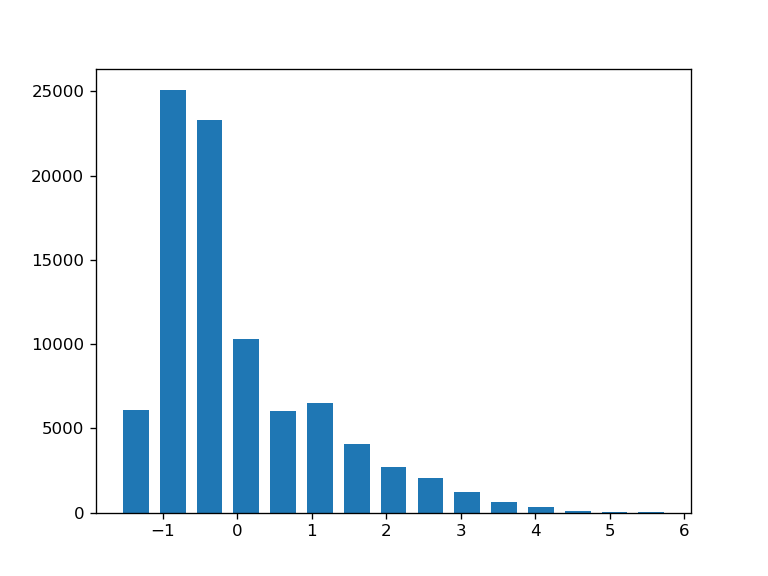

(array([6.1110e+03, 2.5060e+04, 2.3265e+04, 1.0306e+04, 6.0220e+03,
        6.5290e+03, 4.0790e+03, 2.7290e+03, 2.0450e+03, 1.2240e+03,
        6.1000e+02, 3.0600e+02, 1.2100e+02, 3.8000e+01, 9.0000e+00]),
 array([-1.60569293, -1.11163822, -0.61758351, -0.1235288 ,  0.37052591,
         0.86458062,  1.35863533,  1.85269004,  2.34674475,  2.84079946,
         3.33485417,  3.82890889,  4.3229636 ,  4.81701831,  5.31107302,
         5.80512773]),
 <a list of 15 Patch objects>)

In [15]:
plt.hist(np.log(df_meta['P_ogle']),bins=15,rwidth=0.7)

In [16]:
df_meta['P_ogle'].min()

0.2007504

## Entrenamiento

<IPython.core.display.Javascript object>


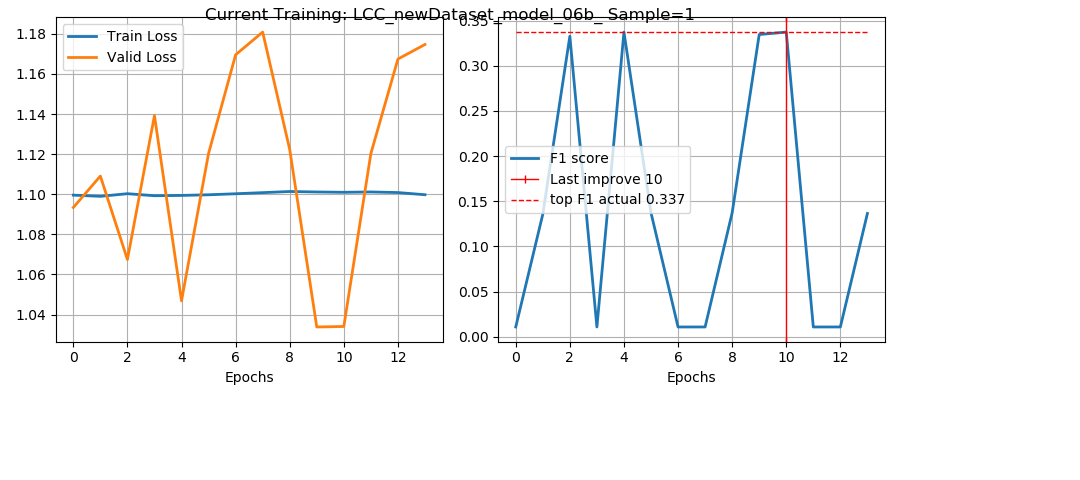


Begin Training new Dataset with Periods


KeyboardInterrupt: 

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True, sharex=True)
top5f1=list()
prompt="Training new Dataset with Periods"
print("\nBegin",prompt)
for c, VVV in enumerate([VVV_pO]):
    # DataLoaders
    train_loader, valid_loader = make_dataloaders(VVV,use_IDS,train_size,test_size)
    for s in [1,2]: 
        comentario = 'P'+str(3)+"_sample_"+str(s)
        path_full = path+comentario+'.pt'
        path_save = path_results+model_name+comentario+'.png'
        
        # ENTRENAR
        modelo=MLP_last(use_period=False,use_amp=False)
        if use_gpu:
            modelo=modelo.cuda()
        topf1 = training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, valid_loader,path_full,path_save,fig,ax,top5f1,model_name,s)
        top5f1.append(topf1)

# return f1 mean, f1 std
print("Results: F1-Score-Macro mean=",np.mean(top5f1),"F1-Score-Macro std=",np.std(top5f1))
print("End",prompt)
print("-------END-------")

In [33]:
cuda.is_available()

True

- Volver atras y sacar periodo como feature
  - Modulo con Booleanos para no modificar a cada rato.
- usar periodo OGLE
- RECREAR RESULTADOS
- si sigue habiendo inestabilidad, revisar Dataset:
  - que las curvas se estén doblando bien
  - si las etiquetas esten bien
  - distribucion de clases